In [1]:
import sys
sys.path.append('../..')
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import cuda
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.models.mobilenet import mobilenet_v2

# DLBio and own scripts
from DLBio.pytorch_helpers import get_device
import ds_ear_siamese
import transforms_data as td
from helpers import cuda_conv
from metrics import conf_matrix_elements
from siamese_network_train import Training
from ContrastiveLossFunction import ContrastiveLoss
from NN_Siamese import SiameseNetwork

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,value1, val_iteration, value2, label1, label2, plt_number):
    plt.figure(plt_number)
    plt.plot(iteration,value1, label=label1)
    plt.plot(val_iteration,value2, label=label2)
    plt.legend()
    plt.grid()

In [3]:
# Set Up All Configurations here
class Config():
    #1. Boolean ändern
    #2. FC-Layer auf Bild anpassen
    #3. LR auf 0,0005
    NN_SIAMESE = False
    dataset_dir = '../dataset/'
    # training_dir = "../data/ears/training/"
    # testing_dir = "../data/ears/testing/"
    train_batch_size = 32
    val_batch_size = 32
    test_batch_size = 1
    vis_batch_size = 8
    num_workers = 3
    
    EPOCHS= 100
    LEARNINGRATE = 0.001
    WEIGHT_DECAY = 0

    TRESHOLD_VER = 0.8
    a = 0

In [4]:
# define indicies to split Data
N = len(ds_ear_siamese.get_dataset(data_path=Config.dataset_dir, transform_mode='size_only'))
print(N)
n_80 = int(round(.8*N))
n_70 = int(round(.7*N))
n_60 = int(round(.6*N))
n_20 = int(round(.2*N))
n_10 = int(round(.1*N))

rand_indices = np.random.permutation(N)
train_indices = rand_indices[:n_70]
val_indices = rand_indices[n_70:n_70+n_20]
test_indices = rand_indices[n_70+n_20:]


# definde data loader
# dl_train = ds_ear_siamese.get_dataloader(
train_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=train_indices,
    batch_size=Config.train_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese', # TODO switch to another transform?
    should_invert = False
)

val_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=val_indices,
    batch_size=Config.val_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese_valid_and_test',
    should_invert = False
)
# dl_test = ds_ear_siamese.get_dataloader(
test_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=test_indices,
    batch_size=Config.test_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese_valid_and_test',
    should_invert = False
)

vis_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=train_indices,
    batch_size=Config.vis_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    should_invert = False
)

['alexander_bec', 'alissa_buh', 'david_fau', 'falco_len', 'felix_mec', 'gregor_spi', 'hammam_als', 'janna_qua', 'jesse_kru', 'konrad_von', 'marina_fri', 'mila_wol', 'mohammed_muh', 'moritz_bor', 'nils_loo', 'robert_kle', 'sarah_feh', 'yannik_obe']
1440


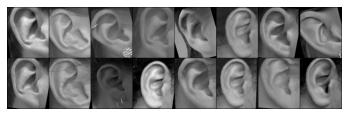

[[0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [5]:
# visualize some data....
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(make_grid(concatenated))
print(example_batch[2].numpy())

In [6]:
# Definde Model and load to device
if Config.NN_SIAMESE == False:
    model = mobilenet_v2(pretrained=True)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    #model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=10)
    
    layers = []
    for layer in model.features[0]:
        layers.append(layer)
    model.features[0][0] = nn.ReflectionPad2d(1)
    model.features[0][1] = layers[0]
    model.features[0][2] = layers[1]
    model.features[0].add_module('3', layers[2])
    
    model.classifier = nn.Sequential(*list(model.classifier.children())[:-2])
    
    #model = torch.nn.Sequential(*(list(model.children())[:-1]))
    #model = model.features

else:
    model = SiameseNetwork()


device = get_device()
print(device)
model.to(device)

contrastive_loss_siamese = ContrastiveLoss(2.0)
optimizer_siamese = torch.optim.Adam(model.parameters(),lr = Config.LEARNINGRATE)

cuda:0


In [7]:
#To Define which Layers we want to train
for param in model.parameters():
    param.requires_grad = False

layers = list(model.children())[0]
sub_layer = list(layers.children())
unfreezed = [1, 12, 13, 14, 15, 16, 17, 18]
for u in unfreezed:
    for param in sub_layer[u].parameters():
        param.requires_grad = True

In [8]:
# To show trainable parameters
from DLBio.pytorch_helpers import get_num_params

get_num_params(model,True)

1918784

88

Epoch number 32
 Current val_loss 0.2233
 Current val_acc 93.75

Epoch number 33
 Current loss 0.1502
 Current acc 100.00

Epoch number 33
 Current loss 0.1510
 Current acc 100.00

Epoch number 33
 Current loss 0.1632
 Current acc 96.88

Epoch number 33
 Current loss 0.1073
 Current acc 100.00

Epoch number 33
 Current val_loss 0.1244
 Current val_acc 100.00

Epoch number 34
 Current loss 0.1853
 Current acc 100.00

Epoch number 34
 Current loss 0.1899
 Current acc 93.75

Epoch number 34
 Current loss 0.1652
 Current acc 96.88

Epoch number 34
 Current loss 0.1222
 Current acc 100.00

Epoch number 34
 Current val_loss 0.2000
 Current val_acc 93.75

Epoch number 35
 Current loss 0.0971
 Current acc 100.00

Epoch number 35
 Current loss 0.2288
 Current acc 93.75

Epoch number 35
 Current loss 0.2209
 Current acc 93.75

Epoch number 35
 Current loss 0.1232
 Current acc 96.88

Epoch number 35
 Current val_loss 0.1678
 Current val_acc 100.00

Epoch number 36
 Current loss 0.1290
 Curren

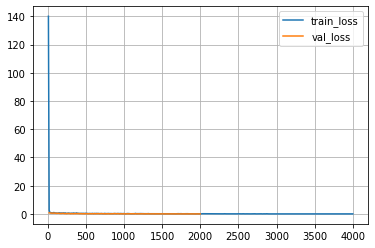

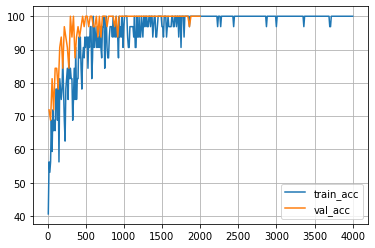

In [9]:
training = Training(model=model, optimizer=optimizer_siamese,train_dataloader=train_dataloader, val_dataloader=val_dataloader, loss_contrastive=contrastive_loss_siamese, nn_Siamese=Config.NN_SIAMESE, THRESHOLD=Config.TRESHOLD_VER)

counter, loss_history, val_counter, val_loss_history, acc_history, val_acc_history = training(Config.EPOCHS)
show_plot(counter, loss_history,val_counter, val_loss_history,'train_loss', 'val_loss',1)
show_plot(counter, acc_history,val_counter, val_acc_history,'train_acc', 'val_acc', 2)

In [10]:
if Config.NN_SIAMESE:
    def generate_output(img_in, img_in2):
        return model(
                cuda_conv(Variable(img_in)),
                cuda_conv(Variable(img_in2))
                )
else:
    def generate_output(img_in):
        return model(
                cuda_conv(Variable(img_in))
                )   

In [11]:
# Evaluate the Test set
tn_all, fp_all, fn_all, tp_all = 0, 0, 0, 0

for i, data in enumerate(test_dataloader):
    # use training class for data extraction
    label, output1, output2 = training.get_label_outputs(data)
    # get the elements for a confusion matrix
    tn, fp, fn, tp = conf_matrix_elements(img0, img1)
    tn_all += tn
    fp_all += fp
    fn_all += fn
    tp_all += tp


NameError: name 'img0' is not defined

In [12]:
iter_batches = iter(test_dataloader)
accuracy_count = 0.0
matches = []
non_matches = []
for i in range(len(iter_batches)):
    # batch size schould be 1 to throw no errors in accessing the next(iter_batches) 
    img0, img1, label = next(iter_batches)
    # appends images to matches, if label is 0 (0 = same)
    ((matches, non_matches)[int(label)]).append( (img0,img1) )

# iterate through both lists and compare the distances of the current entries
for m, n in zip(matches, non_matches):
    # get the models output vectors for the images
    
    if Config.NN_SIAMESE:
        match_out1, match_out2 = generate_output(m[0], m[1])
        non_match_out1, non_match_out2 = generate_output(n[0], n[1])
    else:
        match_out1 = generate_output(m[0])
        match_out2 = generate_output(m[1])                 
        non_match_out1 = generate_output(n[0])
        non_match_out2 = generate_output(n[1])
        
    # positive-positive, positive-negative distance
    euclidean_distance_pp = F.pairwise_distance(match_out1, match_out2)
    #euclidean_distance_pn = F.pairwise_distance(non_match_out1, non_match_out2)
    
    # format variables
    fmt_id = '{:<12}'
    fmt_eucl = '{:<.3f}'
    # increase accouracy count if p-p was lower than p-n
    if(euclidean_distance_pp < Config.TRESHOLD_VER): accuracy_count += 1
    # print current stats
    print(fmt_id.format('pos-pos: '), fmt_eucl.format( euclidean_distance_pp.item()) )
    # print(fmt_id.format('pos-neg: '),fmt_eucl.format( euclidean_distance_pn.item()) )
    print(fmt_id.format('Acc. count: '), '{:>.0f}'.format(accuracy_count), '\n')

# divide by the minimum length (zip function regulated the steps to the minimum)
print(fmt_id.format('Overall (estimated) accuracy: '), fmt_eucl.format( 100 * accuracy_count / min(len(matches), len(non_matches)) ), ' %')

pos-pos:     0.471
Acc. count:  1 

pos-pos:     0.338
Acc. count:  2 

pos-pos:     0.360
Acc. count:  3 

pos-pos:     0.544
Acc. count:  4 

pos-pos:     0.435
Acc. count:  5 

pos-pos:     0.098
Acc. count:  6 

pos-pos:     0.223
Acc. count:  7 

pos-pos:     0.114
Acc. count:  8 

pos-pos:     0.290
Acc. count:  9 

pos-pos:     0.061
Acc. count:  10 

pos-pos:     0.184
Acc. count:  11 

pos-pos:     0.000
Acc. count:  12 

pos-pos:     0.603
Acc. count:  13 

pos-pos:     0.268
Acc. count:  14 

pos-pos:     0.365
Acc. count:  15 

pos-pos:     0.212
Acc. count:  16 

pos-pos:     0.150
Acc. count:  17 

pos-pos:     0.357
Acc. count:  18 

pos-pos:     0.000
Acc. count:  19 

pos-pos:     0.189
Acc. count:  20 

pos-pos:     0.519
Acc. count:  21 

pos-pos:     0.252
Acc. count:  22 

pos-pos:     0.254
Acc. count:  23 

pos-pos:     0.093
Acc. count:  24 

pos-pos:     0.429
Acc. count:  25 

pos-pos:     0.297
Acc. count:  26 

pos-pos:     0.440
Acc. count:  27 

pos-pos:  

In [13]:
#model = torch.load('/Users/falcolentzsch/Develope/Bachelorthesis/Bachelorthesis/models/model.pt')

In [14]:
#torch.save(model,'/nfshome/lentzsch/Documents/Bachelorarbeit/Bachelorthesis/models/model_MN_1.pt')